In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pyspark as ps

spark = ps.sql.SparkSession.builder \
        .master("local[4]") \
        .appName("df lecture") \
        .getOrCreate()

sc = spark.sparkContext

In [59]:
# %load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import cleaner

%matplotlib inline

In [4]:
review_df = spark.read.json('../break_week/data/dataset/review.json')

In [5]:
review_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: long (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)



In [6]:
review_df.createTempView("review")

In [7]:
df = spark.sql("SELECT * FROM review WHERE cool > 0 ORDER BY cool DESC")
df.show(1)

+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|      date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
|DN0b4Un8--Uf6SEWL...|1105|2010-08-01| 1481|A8mLBytNM2zmjHgSp...|    1|In retrospect, I ...|  3364|qiTy11I-yp6foxIgh...|
+--------------------+----+----------+-----+--------------------+-----+--------------------+------+--------------------+
only showing top 1 row



In [8]:
df1 = spark.sql("SELECT business_id, user_id, date, stars, text FROM review")
df1.show(5)

+--------------------+--------------------+----------+-----+--------------------+
|         business_id|             user_id|      date|stars|                text|
+--------------------+--------------------+----------+-----+--------------------+
|0W4lkclzZThpx3V65...|bv2nCi5Qv5vroFiqK...|2016-05-28|    5|Love the staff, l...|
|AEx2SYEUJmTxVVB18...|bv2nCi5Qv5vroFiqK...|2016-05-28|    5|Super simple plac...|
|VR6GpWIda3SfvPC-l...|bv2nCi5Qv5vroFiqK...|2016-05-28|    5|Small unassuming ...|
|CKC0-MOWMqoeWf6s-...|bv2nCi5Qv5vroFiqK...|2016-05-28|    5|Lester's is locat...|
|ACFtxLv8pGrrxMm6E...|bv2nCi5Qv5vroFiqK...|2016-05-28|    4|Love coming here....|
+--------------------+--------------------+----------+-----+--------------------+
only showing top 5 rows



In [9]:
user_df = spark.read.json('../break_week/data/dataset/user.json')

In [10]:
user_df.createTempView("user")

In [11]:
business_df = spark.read.json("../break_week/data/dataset/business.json")

In [12]:
business_df.createTempView("business")

In [13]:
df2 = spark.sql("SELECT name, state, city, address, business_id, categories, stars, postal_code FROM business")
df2.show(5)

+--------------------+-----+--------------+--------------------+--------------------+--------------------+-----+-----------+
|                name|state|          city|             address|         business_id|          categories|stars|postal_code|
+--------------------+-----+--------------+--------------------+--------------------+--------------------+-----+-----------+
|    Dental by Design|   AZ|     Ahwatukee|4855 E Warner Rd,...|FYWN1wneV18bWNgQj...|[Dentists, Genera...|  4.0|      85044|
| Stephen Szabo Salon|   PA|      McMurray|  3101 Washington Rd|He-G7vWjzVUysIKrf...|[Hair Stylists, H...|  3.0|      15317|
|Western Motor Veh...|   AZ|       Phoenix|6025 N 27th Ave, ...|KQPW8lFf1y5BT2Mxi...|[Departments of M...|  1.5|      85017|
|    Sports Authority|   AZ|         Tempe|5000 Arizona Mill...|8DShNS-LuFqpEWIp0...|[Sporting Goods, ...|  3.0|      85282|
|Brick House Taver...|   OH|Cuyahoga Falls|        581 Howe Ave|PfOCPjBrlQAnz__NX...|[American (New), ...|  3.5|      44221|


In [14]:
df3 = spark.sql("SELECT new.user_name, new.user_id, new.business_id, new.friends, \
                b.name AS business_name, b.state, b.city, b.address, b.categories, b.stars AS bus_star,\
                new.text, new.stars AS review_star \
                FROM \
                    (SELECT u.name AS user_name, r.user_id, r.business_id, r.text, r.stars, u.friends \
                    FROM review AS r \
                    LEFT JOIN user AS u \
                    ON r.user_id = u.user_id) AS new\
                INNER JOIN business as b\
                ON new.business_id = b.business_id \
                WHERE ARRAY_CONTAINS(b.categories, 'Restaurants')")
df3.show(5)

+---------+--------------------+--------------------+--------------------+--------------------+-----+---------+--------------------+--------------------+--------+--------------------+-----------+
|user_name|             user_id|         business_id|             friends|       business_name|state|     city|             address|          categories|bus_star|                text|review_star|
+---------+--------------------+--------------------+--------------------+--------------------+-----+---------+--------------------+--------------------+--------+--------------------+-----------+
|   Justin|0y8ORuC2X1i1UF6SG...|--9e1ONYQuAa-CB_R...|[sf-8AusztxHc4o5b...|Delmonico Steakhouse|   NV|Las Vegas|3355 Las Vegas Bl...|[Cajun/Creole, St...|     4.0|WOW.

I came to V...|          5|
|    Shaun|9spixZHaqC1JeN1ld...|--9e1ONYQuAa-CB_R...|[jB5Imm55MMANvOlY...|Delmonico Steakhouse|   NV|Las Vegas|3355 Las Vegas Bl...|[Cajun/Creole, St...|     4.0|We had scheduled ...|          2|
|        J|A4GnBOU7Z

In [15]:
df3.createTempView("restuarant_review")

In [16]:
df3.count()

3221419

In [17]:
df4 = df3.where("review_star = 1")
df5 = df3.where("review_star = 5")

In [18]:
df4.count()

362143

In [19]:
df4.select("text").show(3, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
#Subsetting 5000 entries from reviews with 1 star rating
df6 = df4.limit(5000).toPandas()

In [21]:
df6.head()

,user_name,user_id,business_id,friends,business_name,state,city,address,categories,bus_star,text,review_star
0,B,QtHv6STU4sddCPOBXEYTaA,--9e1ONYQuAa-CB_Rrw7Tw,"[KqkJ_tK3Xw9hTUqD3UoLHA, QKa4Tsp2E8RTztzwUXi5y...",Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,Deserves a zero. I was highly disappointed. We...,1
1,Honesty,P1TybPWySTf4wPrIrk69Ew,--9e1ONYQuAa-CB_Rrw7Tw,[],Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,This was by far the worst meal I have ever had...,1
2,Los,n0y7p7B1NMia_3lpk7xK3A,--9e1ONYQuAa-CB_Rrw7Tw,"[zc5Jra-F0Z017yYq4o5gaw, byRPTEfr8eFDaZzAb5o1g...",Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,I visited this place with a few of my friends ...,1
3,Pat,qUPAHTfAocAxo6aBrXiPbA,--9e1ONYQuAa-CB_Rrw7Tw,[],Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,Ambiance is zilch -- honestly I don't know how...,1
4,Sree,RKY2LhKjMDOrHFOvu_WcYA,--9e1ONYQuAa-CB_Rrw7Tw,"[tvGzwoizwKtZvVZ_lrnr8A, LNHtt3ydkZ14D2ZXXs6Gx...",Delmonico Steakhouse,NV,Las Vegas,3355 Las Vegas Blvd S,"[Cajun/Creole, Steakhouses, Restaurants]",4.0,Went alone to eat here and the experience was ...,1


In [22]:
df6["text"][0]

"Deserves a zero. I was highly disappointed. We went for my husband's birthday expecting a meal worthy of the $200 we spent.  The food was very bland. I was so upset I didn't even bother to order dessert.  I thought if dessert tastes anything like dinner, I'm not going to bother. Noone bothered to ask how the food was. The chef didn't bother to come to our table,  even though he spoke to individuals at the three other tables surrounding us. Thank God I opted for the indoor gondola ride after dinner which helped to improve my mood for the evening.  I won't be back here or to any of his restaurants. I'm a good person so I still left a very generous tip;  after all it wasn't the waiter's fault the food was just ok."

In [23]:
#creating a list of review text from dataframe
corpus = list(df6.text)

In [24]:
#viewin the first two texts from the corpus list
corpus[:2]

["Deserves a zero. I was highly disappointed. We went for my husband's birthday expecting a meal worthy of the $200 we spent.  The food was very bland. I was so upset I didn't even bother to order dessert.  I thought if dessert tastes anything like dinner, I'm not going to bother. Noone bothered to ask how the food was. The chef didn't bother to come to our table,  even though he spoke to individuals at the three other tables surrounding us. Thank God I opted for the indoor gondola ride after dinner which helped to improve my mood for the evening.  I won't be back here or to any of his restaurants. I'm a good person so I still left a very generous tip;  after all it wasn't the waiter's fault the food was just ok.",
 "This was by far the worst meal I have ever had.  Not steak,   Meal!  I went with a group of 4, only 1 steak was cooked correctly and it was super fatty. I had a filet ordered medium to medium well black, it showed up well done with no char whatsoever.  My friend ordered he

In [25]:
# nltk.download("wordnet")
# nltk.download("stopwords")

In [26]:
sw = set(stopwords.words("english"))

In [27]:
tokenizer = RegexpTokenizer("[\w']+")
st = PorterStemmer()

cleaned = [" ".join([st.stem(word) for word in tokenizer.tokenize(doc) 
            if word.isdigit() == False and word not in sw]) 
            for doc in corpus]

In [28]:
cleaned[:2]

["deserv zero I highli disappoint We went husband' birthday expect meal worthi spent the food bland I upset I even bother order dessert I thought dessert tast anyth like dinner i'm go bother noon bother ask food the chef bother come tabl even though spoke individu three tabl surround us thank god I opt indoor gondola ride dinner help improv mood even I back restaur i'm good person I still left gener tip waiter' fault food ok",
 "thi far worst meal I ever not steak meal I went group steak cook correctli super fatti I filet order medium medium well black show well done char whatsoev My friend order blue show rare My husband' fine like I said super fatti the friend cook well along snottiest look disgust foie gra I ever seen bottom line_ go vega great meal suck all suck Go somewher els 100pp"]

In [29]:
tfidf_vectorizer= TfidfVectorizer(max_df=0.95, min_df=2,
                                stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(cleaned)

# tfidf_vectorizer.vocabulary_

In [30]:
X = tfidf.toarray()

In [31]:
X.shape

(5000, 6433)

In [32]:
lsa = TruncatedSVD(n_components=2000, random_state=42)

In [33]:
lsa.fit(X)

TruncatedSVD(algorithm='randomized', n_components=2000, n_iter=5,
       random_state=42, tol=0.0)

In [34]:
exp_var = lsa.explained_variance_ratio_
# exp_var

In [35]:
s = lsa.singular_values_
# s

In [36]:
#2000 topics explains 92% of the variance
sum(exp_var)

0.92030732566545503

In [37]:
lsa.components_.shape

(2000, 6433)

In [38]:
terms = np.array(tfidf_vectorizer.get_feature_names())

In [39]:
topic_list = []
for i, topic in enumerate(lsa.components_, 1):
    topic_term = sorted(zip(topic, terms), key= lambda x: x[0], reverse=True)[:13]
    topics = [x[1] for x in topic_term]
    topic_list.extend(topics)
    print("Topic {}: {}".format(i, topics))

Topic 1: ['food', 'order', 'place', 'servic', 'time', 'wait', 'minut', 'like', 'ask', 'tabl', 'good', 'came', 'got']
Topic 2: ['wait', 'minut', 'tabl', 'ask', 'seat', 'drink', 'manag', 'server', 'told', 'said', 'walk', 'hostess', 'bar']
Topic 3: ['pizza', 'order', 'chees', 'deliveri', 'crust', 'wing', 'sauc', 'salad', 'locat', 'slice', 'phone', 'minut', 'hut']
Topic 4: ['pizza', 'buffet', 'servic', 'food', 'place', 'horribl', 'rude', 'bad', 'worst', 'wynn', 'custom', 'wait', 'peopl']
Topic 5: ['buffet', 'tabl', 'seat', 'bar', 'dinner', 'pizza', 'reserv', 'hostess', 'crab', 'wynn', 'salad', 'said', 'dessert']
Topic 6: ['wait', 'minut', 'food', 'buffet', 'pizza', 'order', 'hour', 'min', 'cold', 'got', 'line', 'worth', 'chicken']
Topic 7: ['buffet', 'time', 'drive', 'wait', 'order', 'locat', 'line', 'smoothi', 'sandwich', 'wynn', 'crab', 'custom', 'employe']
Topic 8: ['order', 'buffet', 'servic', 'sushi', 'ask', 'manag', 'rude', 'waitress', 'came', 'charg', 'crab', 'roll', 'server']
Topic

Topic 151: ['sat', 'worth', 'left', 'gross', 'wrong', 'expect', 'look', 'll', 'check', 'veri', 'card', 'burnt', 'min']
Topic 152: ['return', 'bland', 'visit', 'love', 'famili', 'thing', 'beef', 'took', 'dirti', 'make', 'italian', 'happi', 'beer']
Topic 153: ['attitud', 'shrimp', 'person', 'expens', 'breakfast', 'salsa', 'dine', 'year', 'disgust', 'bland', 'parti', 'care', 'bartend']
Topic 154: ['make', 'wife', 'return', 'alway', 'dine', 'said', 'forgot', 'area', 'old', 'paid', 'lobster', 'final', 'employe']
Topic 155: ['hostess', 'piec', 'chang', 'someth', 'half', 'pay', 'poor', 'plate', 'sit', 'flavor', 'sure', 'just', 'pretti']
Topic 156: ['thai', 'bland', 'pad', 'experi', 'noth', 'old', 'new', 'attitud', 'cook', 'phone', 'dont', 'took', 'hostess']
Topic 157: ['overpr', 'person', 'differ', 'today', 'care', 'bread', 'fish', 'mani', 'dish', 'bbq', 'fresh', 'best', 'second']
Topic 158: ['right', 'pork', 'appet', 'hostess', 'gross', 'dessert', 'half', 'special', 'line', 'owner', 'left', 

Topic 750: ['everytim', 'book', 'step', 'attempt', 'stood', 'public', 'falafel', 'proceed', 'town', 'fuck', 'izakaya', 'buy', 'date']
Topic 751: ['popey', 'onlin', 'build', 'world', 'takeout', 'patti', 'ined', 'broccoli', 'idea', 'anywher', 'rest', 'member', 'authent']
Topic 752: ['shawarma', 'everytim', 'chain', 'appear', 'concern', 'mall', 'state', 'space', 'fuck', 'court', 'gluten', 'hype', 'origin']
Topic 753: ['world', 'date', 'stuff', 'ahead', 'omelett', 'countri', 'hamburg', 'correct', 'lose', 'buck', 'clear', 'wipe', 'singl']
Topic 754: ['hello', 'omelett', 'wendy', 'cheddar', 'overr', 'woman', 'remak', 'mostli', 'hype', 'burn', 'booth', 'monday', 'dozen']
Topic 755: ['hit', 'rotten', 'obvious', 'wipe', 'event', 'realiz', 'takeout', 'bottl', 'consist', 'patron', 'greas', 'claim', 'cancel']
Topic 756: ['respect', 'spent', 'knew', 'fork', 'chipotl', 'slowest', 'quickli', 'prepar', 'mom', 'figur', 'local', 'cockroach', 'stuff']
Topic 757: ['attend', 'present', 'oven', 'nope', 'bea

Topic 1263: ['underwhelm', 'rave', 'minuet', 'slider', 'calamari', 'confront', 'rubio', 'wrapper', 'sloppi', 'unsatisfi', 'yellow', 'blacken', 'lover']
Topic 1264: ['summerlin', 'cute', 'fond', 'hospit', 'discount', 'awe', 'megan', 'regard', 'lobbi', 'oili', 'couldn', 'inconveni', 'ich']
Topic 1265: ['respond', 'clue', 'ramen', 'shred', 'true', 'ich', 'pepsi', 'tuesday', 'block', 'repeatedli', 'ill', 'subpar', 'photo']
Topic 1266: ['sampl', 'textur', 'awhil', 'chicharon', 'chewi', 'tropic', 'insist', 'twenti', 'sh', 'declin', 'irish', 'stroller', 'sticker']
Topic 1267: ['ich', 'textur', 'offic', 'wir', 'kabab', 'beverag', 'wed', 'yuk', 'mcflurri', 'glad', 'hh', 'cri', 'einer']
Topic 1268: ['everywher', 'award', 'movi', 'hazard', 'ive', 'ny', 'peac', 'ha', 'roller', 'shift', 'deni', 'team', 'chose']
Topic 1269: ['chicharon', 'cevich', 'remak', 'wanna', 'curs', 'suffer', 'overwhelm', 'rawhid', 'wed', 'advanc', 'din', 'boil', 'rubberi']
Topic 1270: ['fond', 'particular', 'shawarma', 'gran

In [40]:
word_dict = Counter(topic_list)

In [41]:
df_top = pd.DataFrame.from_dict(word_dict,orient='index', columns=["count"])
df_top.head()

,count
food,7
order,10
place,9
servic,14
time,7


In [42]:
new_df = df_top[df_top["count"] > 20]

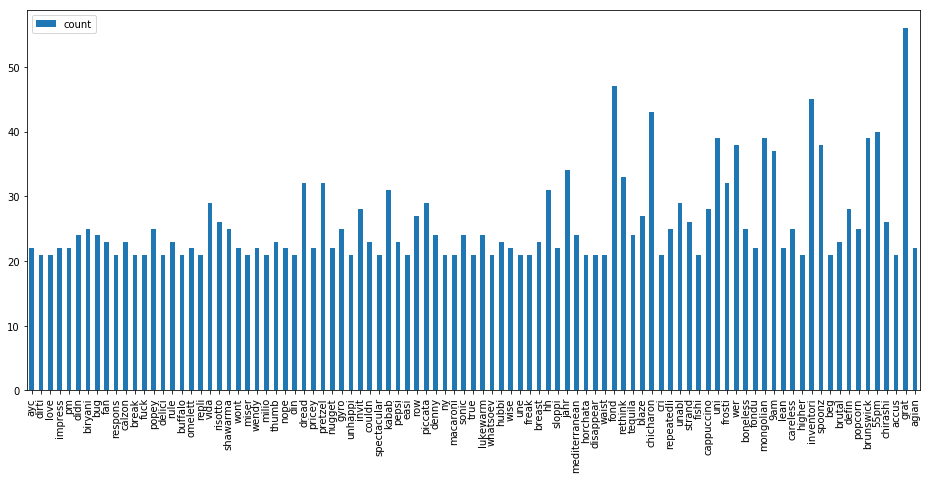

In [43]:
new_df.plot(kind='bar', figsize=(16,7))

In [44]:
df6.groupby("business_id").count()

,user_name,user_id,friends,business_name,state,city,address,categories,bus_star,text,review_star
business_id,,,,,,,,,,,
--9e1ONYQuAa-CB_Rrw7Tw,45,45,45,45,45,45,45,45,45,45,45
-49WY_TEa9ZEcRk_GnuLog,4,4,4,4,4,4,4,4,4,4,4
-7bRnaHp7OHz8KW-THqP4w,7,7,7,7,7,7,7,7,7,7,7
-HLGtKB3XtyawZAuvNoQjQ,3,3,3,3,3,3,3,3,3,3,3
-K3kqmykKlhlB4arCsLHOw,31,31,31,31,31,31,31,31,31,31,31
-R_dMb9Z1eBv_FlYZrrKbw,2,2,2,2,2,2,2,2,2,2,2
-VAsjhmAbKF3Pb_-8rh3xg,4,4,4,4,4,4,4,4,4,4,4
-YSCL35R3g6qqvHordSxVw,1,1,1,1,1,1,1,1,1,1,1
-Yq3_hzWqsPR3s8SLyQ2fQ,1,1,1,1,1,1,1,1,1,1,1


#### Using numpy linalg.svd:

In [45]:
u, s, vt = np.linalg.svd(X)

In [46]:
for i, topic in enumerate(vt, 1):
    topic_term = sorted(zip(topic, terms), key= lambda x: x[0], reverse=True)[:13]
    topics = [x[1] for x in topic_term]
    print("Topic {}: {}".format(i, topics))

Topic 1: ['teuer', 'hieß', 'zweimal', 'sauer', 'süß', 'nächsten', 'nix', 'hallo', 'dacht', 'sech', 'enttäuscht', 'freundlich', 'davon']
Topic 2: ['wait', 'minut', 'tabl', 'ask', 'seat', 'drink', 'manag', 'server', 'told', 'said', 'walk', 'hostess', 'bar']
Topic 3: ['food', 'buffet', 'servic', 'sushi', 'tabl', 'price', 'good', 'restaur', 'terribl', 'server', 'wynn', 'mexican', 'qualiti']
Topic 4: ['order', 'chicken', 'fri', 'got', 'taco', 'came', 'sandwich', 'meal', 'ask', 'sauc', 'salad', 'burger', 'rice']
Topic 5: ['servic', 'food', 'order', 'time', 'horribl', 'place', 'custom', 'locat', 'worst', 'terribl', 'rude', 'drive', 'smoothi']
Topic 6: ['wait', 'minut', 'food', 'buffet', 'pizza', 'order', 'hour', 'min', 'cold', 'got', 'line', 'worth', 'chicken']
Topic 7: ['buffet', 'time', 'drive', 'wait', 'order', 'locat', 'line', 'smoothi', 'sandwich', 'wynn', 'crab', 'custom', 'employe']
Topic 8: ['order', 'buffet', 'servic', 'sushi', 'ask', 'manag', 'rude', 'waitress', 'came', 'charg', 'cr

Topic 78: ['better', 'fri', 'soup', 'waiter', 'burrito', 'said', 'ok', 'hair', 'say', 'check', 'know', 'way', 'locat']
Topic 79: ['wing', 'drive', 'sushi', 'seat', 'staff', 'meat', 'dish', 'employe', 'soup', 'coffe', 'walk', 'drink', 'great']
Topic 80: ['employe', 'want', 'work', 'review', 'seat', 'hair', 'menu', 'qualiti', 'price', 'friend', 'came', 'anyon', 'told']
Topic 81: ['work', 'staff', 'tri', 'price', 'fish', 'deliveri', 'coffe', 'night', 'hair', 'suck', 'cold', 'away', 'worst']
Topic 82: ['serv', 'slow', 'chees', 'say', 'told', 'lunch', 'disgust', 'worth', 'chip', 'disappoint', 'return', 'owner', 'dinner']
Topic 83: ['mexican', 'tri', 'say', 'want', 'work', 'year', 'peopl', 'dirti', 'old', 'soup', 'came', 'price', 'shrimp']
Topic 84: ['told', 'busi', 'great', 'tast', 'disgust', 'sauc', 'shrimp', 'friend', 'experi', 'dirti', 'lunch', 'price', 'beer']
Topic 85: ['peopl', 'mexican', 'smoothi', 'breakfast', 'egg', 'close', 'husband', 'thi', 'waiter', 'pay', 'ok', 'say', 'shrimp']

Topic 708: ['joint', 'ranch', 'cockroach', 'cheddar', 'avail', 'deserv', 'learn', 'oven', 'fun', 'comp', 'mind', 'trash', 'woman']
Topic 709: ['lemon', 'charlott', 'gravi', 'add', 'bell', 'appar', 'season', 'joint', 'cockroach', 'pot', 'jerk', 'basic', 'vida']
Topic 710: ['ingredi', 'children', 'awesom', 'prepar', 'rush', 'entre', 'rip', 'receipt', 'realiz', 'hype', 'charlott', 'combo', 'toast']
Topic 711: ['omelet', 'glove', 'set', 'floor', 'stick', 'bagel', 'typic', 'fuck', 'hold', 'sister', 'regist', 'otherwis', 'updat']
Topic 712: ['number', 'didn', 'forward', 'credit', 'provid', 'weird', 'coke', 'did', 'train', 'advertis', 'patron', 'world', 'pico']
Topic 713: ['consist', 'stood', 'wateri', 'undercook', 'comment', 'fork', 'world', 'choos', 'cockroach', 'write', 'tough', 'updat', 'ring']
Topic 714: ['figur', 'bell', 'buck', 'onli', 'undercook', 'email', 'oyster', 'excus', 'mac', 'season', 'town', 'incred', 'femal']
Topic 715: ['ahead', 'unless', 'wateri', 'tasti', 'spent', 'wednesd

Topic 1236: ['sloppi', 'note', 'freak', 'ipad', 'staf', 'fishi', 'purpos', 'appreci', 'pit', 'macaroni', 'slaw', 'blame', 'classi']
Topic 1237: ['unhappi', 'lukewarm', 'funni', 'hubbi', 'present', 'pricey', 'prep', 'pastrami', 'lobbi', 'ramen', 'lousi', 'fell', 'tostada']
Topic 1238: ['larger', 'bouncer', 'pepsi', 'banana', 'unbeliev', 'certainli', 'staf', 'minor', 'goat', 'funni', 'feed', 'mr', 'code']
Topic 1239: ['una', 'ramen', 'touch', 'nearbi', 'unsatisfi', 'ny', 'shake', 'unhappi', 'awe', 'desper', 'advis', 'lime', 'twenti']
Topic 1240: ['1st', 'market', 'chicharon', 'visibl', 'rubberi', 'cutleri', 'mark', 'forgotten', 'gra', 'damn', 'tropic', 'foie', 'inattent']
Topic 1241: ['sound', 'una', 'disappear', 'wise', 'english', 'delay', 'understaf', 'wrapper', 'straw', 'view', 'sort', 'supervisor', 'closer']
Topic 1242: ['fajita', 'freak', 'teriyaki', 'luckili', 'scrambl', 'utensil', 'gf', 'kimchi', 'natur', 'traffic', 'disabl', 'pricey', 'una']
Topic 1243: ['rais', 'overli', 'crunch

Topic 1830: ['prior', 'unabl', 'receptionist', '9pm', 'younger', 'bulk', 'speaker', 'search', 'heavili', 'soap', '40min', 'chilli', 'mash']
Topic 1831: ['teuer', 'lean', 'faster', 'surprisingli', 'toler', 'dissatisfi', 'cpk', 'hundr', 'tongu', 'gourmet', 'becam', 'admit', 'bike']
Topic 1832: ['spoonz', 'premium', 'doesnt', 'legend', 'boat', 'moder', 'rost', 'accur', 'self', 'nose', 'snap', 'direct', 'yellowtail']
Topic 1833: ['estim', 'scarc', 'spread', 'ripoff', 'brampton', 'profit', 'horrif', 'written', 'wave', 'tso', 'po', 'loudli', 'shuttl']
Topic 1834: ['speaker', 'rethink', 'yucki', 'rant', 'condiment', 'surprisingli', '4x', 'sober', 'proport', '9am', 'hassl', 'pumpkin', 'arab']
Topic 1835: ['careless', 'somebodi', 'accus', 'mea', 'lifetim', 'thanksgiv', 'recomend', 'shall', 'prior', 'doesnt', 'purpos', 'clock', 'whenev']
Topic 1836: ['mood', 'shadi', 'spoonz', 'ceil', 'atlanta', 'anniversari', 'memor', 'metal', 'cappuccino', 'slightli', 'dime', 'coconut', 'bear']
Topic 1837: ['w

Topic 2266: ['tuscan', 'minc', 'survey', 'pee', 'lady', 'spilt', 'kabob', 'buff', 'hint', 'blueberri', 'settl', 'steeler', 'faster']
Topic 2267: ['cabbag', 'guarante', 'grant', 'exclus', 'repost', 'googl', 'toe', 'challeng', 'notifi', 'mistreat', 'hat', 'blend', 'melon']
Topic 2268: ['unfair', 'exchang', 'capit', 'mistreat', 'hairi', 'substanc', 'fals', 'discov', 'brampton', 'snooti', 'masala', 'grouper', 'tastebud']
Topic 2269: ['potion', 'villag', 'aria', 'absurd', 'toughest', 'discrimin', 'bawarchi', 'honk', 'minc', 'pear', 'tastebud', 'reccomend', 'irv']
Topic 2270: ['mistreat', 'song', 'grotesqu', 'warmer', 'comeback', 'aria', 'record', 'residu', 'latt', 'wanton', 'voicemail', 'accur', 'shuffl']
Topic 2271: ['snotti', 'jeff', 'sooo', 'googl', 'minc', 'flan', 'vistancia', 'parasit', 'squish', 'screen', 'ca', 'cuisin', 'failur']
Topic 2272: ['slowli', 'mocha', 'mint', 'maitre', 'slot', 'fewer', 'whomev', 'ideal', 'lean', 'teeth', 'edg', 'cob', 'signal']
Topic 2273: ['beach', 'accid'

Topic 3194: ['stinki', 'rim', 'visitor', 'resv', 'blankli', '30am', 'dynamit', 'matt', 'caramel', 'burden', 'intestin', 'hefti', 'chicago']
Topic 3195: ['landri', 'stinki', 'reorder', 'unknown', 'cholula', 'loin', 'caterpillar', 'outdoor', 'shaker', 'recept', 'task', 'humili', 'china']
Topic 3196: ['rellano', 'sarcast', 'fujo', '30min', 'creami', 'spite', 'chit', 'romain', 'prohibit', 'requir', 'melon', 'souvlaki', 'worthless']
Topic 3197: ['sock', 'arrang', 'taker', 'nausea', 'twist', 'ocean', 'entertain', 'shawn', 'flaki', 'sack', 'drawer', 'concis', 'label']
Topic 3198: ['apathet', 'unbear', 'poorest', 'instant', 'chest', 'oscar', 'suddenli', 'speedi', 'eclect', 'torn', 'plaster', 'coleslaw', 'uneth']
Topic 3199: ['popeye', 'toughest', 'burden', 'plow', 'tall', 'b4', 'smashburg', 'barley', 'popper', 'jefe', 'shovel', 'ocean', 'chit']
Topic 3200: ['caper', 'function', 'swarm', 'seam', 'underneath', 'equip', 'carna', 'engag', 'saute', 'overs', 'panini', 'thereaft', 'secret']
Topic 320

Topic 3733: ['vanish', 'sauci', 'astonish', 'unaccommod', 'bolognes', 'mizithra', 'traci', 'steadili', 'decaf', 'nastiest', 'tshirt', 'lux', 'michelina']
Topic 3734: ['clog', 'shaker', 'skirt', 'lux', 'smear', 'fumbl', 'calcul', 'impli', 'torn', 'er', 'graini', 'rehears', 'dislik']
Topic 3735: ['scurri', 'butteri', 'ahi', 'trashi', 'nativ', 'resolut', 'eclect', 'porridg', 'uneth', 'urg', 'disrepair', 'dislik', 'snarki']
Topic 3736: ['wifi', 'hanger', 'washer', 'thanh', 'scold', 'furthermor', 'chart', 'visitor', 'hostag', 'unreal', 'uncov', 'despar', 'remaind']
Topic 3737: ['cornbread', 'progress', 'unbear', 'tempt', 'assort', 'underdon', 'accomod', 'fingernail', 'wisconsin', 'nonetheless', 'splash', 'sanitari', 'approx']
Topic 3738: ['mt', 'rung', 'siracha', 'souvlaki', 'kebab', 'simonetti', 'jamba', 'horseradish', 'tha', 'disagre', 'caramel', 'af', 'helper']
Topic 3739: ['waxhaw', '4pm', 'alien', 'plop', 'memo', 'tattoo', 'unbalanc', 'iron', 'clearer', 'liberti', 'eager', 'hungov', 'r

Topic 4310: ['justifi', 'miscalcul', 'placat', 'thump', '30ish', 'rad', 'ray', 'stellar', 'pollo', 'pastor', 'oversight', 'skewer', 'fundrais']
Topic 4311: ['helper', 'destin', 'gambler', 'modelo', 'rent', 'cautiou', 'adjac', 'pricier', 'rumbl', 'gee', 'cc', 'inspector', 'aggrav']
Topic 4312: ['leak', 'midway', 'protect', 'dice', 'faint', 'goodyear', 'werent', 'yay', 'sakura', 'incom', 'lyche', 'alli', 'tart']
Topic 4313: ['doughi', 'thanh', 'omlett', 'damag', 'brim', 'motto', 'absent', 'shambl', 'cantina', 'enthus', 'fresher', 'shouldn', 'sing']
Topic 4314: ['yuki', 'redo', 'frat', 'uneaten', 'pretend', 'conduct', 'holla', 'bison', 'dealt', 'sakura', 'spl', 'lap', 'totino']
Topic 4315: ['tornado', 'puni', 'fluffi', 'dj', 'fluster', 'concierg', 'grasp', 'disbelief', 'adventur', 'siracha', 'eatabl', 'flock', 'tentacl']
Topic 4316: ['830pm', 'hmmmm', '83rd', 'cozi', 'bentley', 'ugliest', 'weed', 'unbeknownst', 'vile', 'bleh', 'lap', 'shorter', 'roulett']
Topic 4317: ['flush', 'knive', 'd

Topic 4767: ['gooey', 'seller', 'michelin', 'eagl', 'protect', 'campbell', 'rad', 'parfait', 'dublin', 'uncl', 'honour', 'caucasian', 'illinoi']
Topic 4768: ['length', 'procedur', 'sponsor', 'enorm', 'valpak', 'flaccid', 'relax', 'redo', 'slicer', 'bless', 'descent', 'campbell', 'destin']
Topic 4769: ['broil', 'gennaro', 'plug', 'gta', 'downgrad', 'strain', 'string', 'tissu', 'distract', 'lengthi', 'frat', 'lui', 'hurl']
Topic 4770: ['fox', 'depict', 'knowingli', 'downgrad', 'sickli', 'upkeep', 'spars', 'solv', 'unidentifi', 'scienc', 'manager', 'anger', 'goin']
Topic 4771: ['fiber', 'disintegr', 'array', 'fox', 'bobbi', 'hub', 'clariti', 'expressli', 'variou', 'blindfold', 'honour', 'cranberri', 'legitim']
Topic 4772: ['forbid', 'disinfect', 'kate', 'shoddi', '70th', 'rich', 'kiddo', 'ident', 'dearli', 'oblig', 'junior', 'capabl', 'chihuahua']
Topic 4773: ['steril', 'butternut', 'hid', 'lookin', 'ciabatta', 'uhhh', 'refir', '1970', 'moral', 'ma', 'hyena', 'walnut', 'accusatori']
Topic

Topic 5705: ['thier', 'dommag', 'dampen', 'respekt', 'schmeckt', 'geschmack', 'largest', 'hieß', 'hatten', 'carter', 'könne', 'flair', 'pillow']
Topic 5706: ['thigh', 'serviert', 'cleopatra', 'abendessen', 'gibt', 'schnell', 'eindruck', 'bypass', 'rein', 'chime', 'seit', 'mal', 'premad']
Topic 5707: ['ander', 'aforement', 'besser', 'gute', 'lässt', 'fehler', 'bandag', 'agreement', 'heel', 'baguett', 'applewood', 'dysenteri', 'munch']
Topic 5708: ['thingi', 'breadstick', 'schlechten', 'haystack', 'entschuldigt', 'platz', 'shanghaines', 'boister', 'selten', 'niemand', 'greeter', 'rad', 'compt']
Topic 5709: ['besuch', 'coco', 'avec', 'aller', 'besser', 'ewww', 'küche', 'schlechten', 'basement', 'blaster', 'mode', 'fehler', 'bau']
Topic 5710: ['thinli', 'hammer', 'recommand', 'rein', 'sober', 'insert', 'unconcern', 'redskin', 'seit', 'recht', 'qui', 'inexplic', 'exhaust']
Topic 5711: ['thirsti', 'emot', 'quell', 'gringo', 'einen', 'ont', 'daycar', 'jedenfal', 'pedestrian', 'vista', 'mit', 

In [47]:
lemma = WordNetLemmatizer()
cleaned = [" ".join([lemma.lemmatize(word) for word in tokenizer.tokenize(doc) 
            if word.isdigit() == False and word not in sw]) 
            for doc in corpus]

In [48]:
tfidf_vectorizer= TfidfVectorizer(max_df=0.95, min_df=2,
                                stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(cleaned)

In [49]:
X = tfidf.toarray()


In [50]:
lsa = TruncatedSVD(n_components=2000, random_state=42)
lsa.fit(X)
terms = tfidf_vectorizer.get_feature_names()

In [53]:
cleaner.show_topics(lsa.components_, terms, length = 13)

Topic 1: ['food', 'place', 'service', 'time', 'order', 'minute', 'like', 'table', 'good', 'came', 'got', 'ordered', 'restaurant']
Topic 2: ['minute', 'table', 'order', 'waited', 'drink', 'wait', 'asked', 'manager', 'server', 'said', 'told', 'waiting', 'seated']
Topic 3: ['pizza', 'order', 'cheese', 'delivery', 'crust', 'ordered', 'called', 'sauce', 'location', 'salad', 'minute', 'wing', 'slice']
Topic 4: ['service', 'food', 'pizza', 'place', 'buffet', 'horrible', 'rude', 'worst', 'customer', 'bad', 'terrible', 'time', 'slow']
Topic 5: ['buffet', 'table', 'pizza', 'wynn', 'bar', 'sushi', 'crab', 'dinner', 'hostess', 'seated', 'dessert', 'reservation', 'server']
Topic 6: ['buffet', 'order', 'time', 'sandwich', 'location', 'drive', 'line', 'customer', 'employee', 'wynn', 'called', 'wait', 'said']
Topic 7: ['buffet', 'order', 'minute', 'food', 'waited', 'got', 'cold', 'min', 'wait', 'drive', 'line', 'wynn', 'hour']
Topic 8: ['place', 'taco', 'burger', 'mexican', 'food', 'like', 'bar', 'dri

Topic 700: ['proceeded', 'patio', 'world', 'set', 'topping', 'matter', 'ruined', 'closing', 'boba', 'mall', 'treated', 'informed', 'falafel']
Topic 701: ['tasting', 'monday', 'recently', 'sister', 'gravy', 'uncooked', 'contact', 'quite', 'slider', 'crazy', 'nope', 'normal', 'word']
Topic 702: ['thank', 'pathetic', 'leaving', 'included', 'grilled', 'needed', 'threw', 'unprofessional', 'excuse', 'talked', 'atmosphere', 'silverware', 'room']
Topic 703: ['rubbery', 'comment', 'town', 'stayed', 'luck', 'quesadilla', 'miserable', 'gravy', 'online', 'desert', 'paper', 'father', 'receive']
Topic 704: ['awesome', 'im', 'cross', 'shawarma', 'garbage', 'inedible', 'ingredient', 'total', 'edible', 'napkin', 'wouldn', 'pas', 'crappy']
Topic 705: ['dosa', 'everytime', 'mouth', 'broth', 'picture', 'wow', 'diner', 'station', 'chocolate', 'red', 'izakaya', 'chili', 'send']
Topic 706: ['risotto', 'station', 'afternoon', 'add', 'receive', 'general', 'comment', 'certainly', 'total', 'recommended', 'shawar

Topic 1239: ['jahr', 'quickly', 'uncomfortable', 'junk', 'ring', 'understaffed', 'policy', 'raised', 'ridiculously', 'similar', 'wednesday', 'lover', 'kids']
Topic 1240: ['jahr', 'tired', 'alfredo', 'speaking', 'scary', 'texting', 'decoration', 'pastrami', 'gratuity', 'cancelled', 'hazard', 'wonder', 'staying']
Topic 1241: ['sandwhich', 'locked', 'foot', 'attentive', 'cherry', 'guu', 'adult', 'wonton', 'poutine', 'interested', 'shawarma', 'provided', 'pink']
Topic 1242: ['ur', 'sonic', 'jahr', 'form', 'older', 'donut', 'cancel', 'realize', 'juice', 'texture', 'human', 'watch', 'popo']
Topic 1243: ['ball', 'fault', '1st', 'favor', 'pricey', 'btw', 'naan', 'junk', 'boba', 'hello', 'plan', 'el', 'needless']
Topic 1244: ['circus', 'yeah', 'consistently', 'ashamed', 'disgusted', 'cheeseburger', 'buffalo', 'ur', 'consistency', 'watch', 'telling', 'clue', 'replied']
Topic 1245: ['fond', 'nugget', 'watched', 'correctly', 'guu', 'confronted', 'polite', 'flour', 'prime', 'texting', 'link', 'chan